<a href="https://colab.research.google.com/github/auditee/Auditee_SahaChowdhury_Zeotap-Assesment/blob/main/Auditee_SahaChowdhury_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

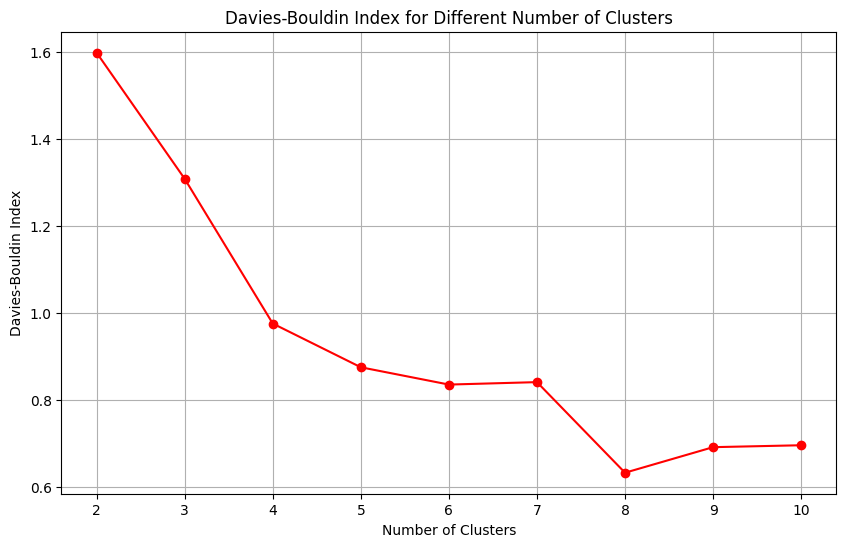

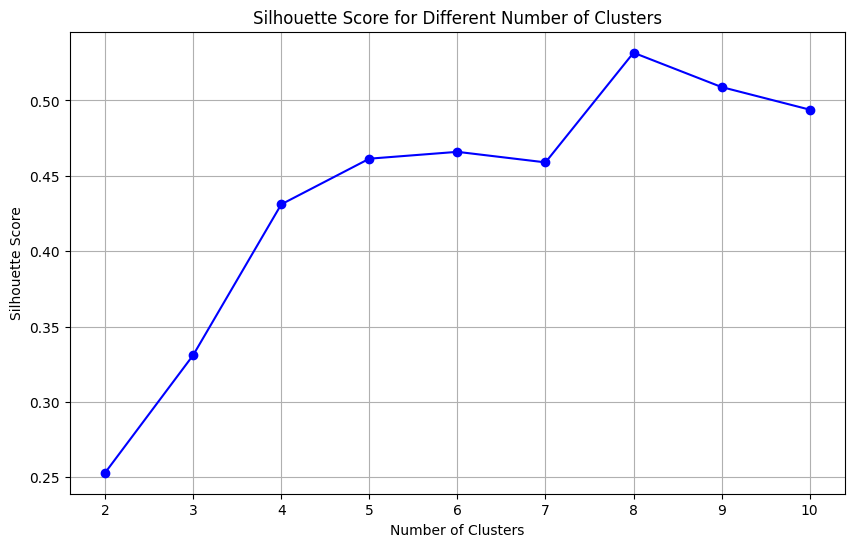

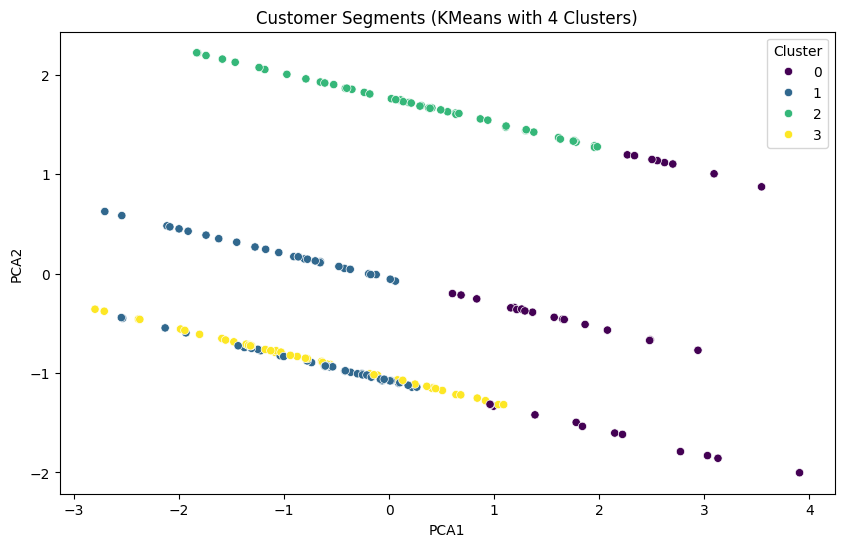

Clustering Results:
Optimal Number of Clusters: 4
Final DB Index: 0.9756717094182625


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

customers = pd.read_csv("/content/Customers.csv")
transactions = pd.read_csv("/content/Transactions.csv")
merged_data = pd.merge(transactions, customers, on="CustomerID")

customer_features = merged_data.groupby("CustomerID").agg({
    "TotalValue": "sum",
    "Quantity": "sum"
}).reset_index()

customer_profiles = pd.merge(customers, customer_features, on="CustomerID", how="left")
customer_profiles.fillna(0, inplace=True)

customer_profiles_numeric = customer_profiles.drop(columns=["CustomerID", "CustomerName", "SignupDate"])
customer_profiles_numeric = pd.get_dummies(customer_profiles_numeric, columns=["Region"], drop_first=True)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_profiles_numeric)

db_index_scores = []
inertia_scores = []
silhouette_scores = []
cluster_range = range(2, 11)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_features)


    db_index = davies_bouldin_score(scaled_features, kmeans.labels_)
    db_index_scores.append(db_index)


    inertia_scores.append(kmeans.inertia_)

    silhouette_avg = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, db_index_scores, marker="o", color="red")
plt.title("Davies-Bouldin Index for Different Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Index")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker="o", color="blue")
plt.title("Silhouette Score for Different Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_profiles["Cluster"] = kmeans.fit_predict(scaled_features)

db_index_final = davies_bouldin_score(scaled_features, customer_profiles["Cluster"])

pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)
customer_profiles["PCA1"] = pca_components[:, 0]
customer_profiles["PCA2"] = pca_components[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue="Cluster", data=customer_profiles, palette="viridis")
plt.title(f"Customer Segments (KMeans with {optimal_clusters} Clusters)")
plt.show()

print("Clustering Results:")
print(f"Optimal Number of Clusters: {optimal_clusters}")
print(f"Final DB Index: {db_index_final}")
customer_profiles.to_csv("Customer_Segmentation.csv", index=False)